In [129]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression




In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [10]:
# Load CSV data
movies_df = pd.read_csv('data/filtered/movies.csv')
actors_df = pd.read_csv('data/filtered/actors.csv')
directors_df = pd.read_csv('data/filtered/directors.csv')
studios_df = pd.read_csv('data/filtered/studios.csv')

In [6]:
# Check missing values only in columns that have them
print("Missing values in movies_df:\n", movies_df.isna().sum()[movies_df.isna().sum() > 0])
print("\nMissing values in actors_df:\n", actors_df.isna().sum()[actors_df.isna().sum() > 0])
print("\nMissing values in directors_df:\n", directors_df.isna().sum()[directors_df.isna().sum() > 0])
print("\nMissing values in studios_df:\n", studios_df.isna().sum()[studios_df.isna().sum() > 0])


Missing values in movies_df:
 theatrical_release_age_rating    2706
dtype: int64

Missing values in actors_df:
 Series([], dtype: int64)

Missing values in directors_df:
 Series([], dtype: int64)

Missing values in studios_df:
 Series([], dtype: int64)


In [13]:
movies_df["theatrical_release_age_rating"].unique()

array(['PG-13', 'R', 'PG', nan, 'G', 'NR', 'NC-17'], dtype=object)

In [14]:

movies_df["theatrical_release_age_rating"].fillna("NR", inplace=True)
print("Missing values in movies_df:\n", movies_df.isna().sum()[movies_df.isna().sum() > 0])


Missing values in movies_df:
 Series([], dtype: int64)


In [4]:
print(f"Movies dataset shape: {movies_df.shape}")
print(f"Actors dataset shape: {actors_df.shape}")
print(f"Directors dataset shape: {directors_df.shape}")
print(f"Studios dataset shape: {studios_df.shape}")

Movies dataset shape: (10599, 9)
Actors dataset shape: (156070, 3)
Directors dataset shape: (5390, 3)
Studios dataset shape: (11445, 3)


# Data split


In [16]:
# Split the data based on time, with validation and test sets randomly split from the same time period.
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15



In [17]:

# Sort movies by date and get cumulative counts per year
year_counts = movies_df['date'].value_counts().sort_index()
total_movies = len(movies_df)
cumulative_ratio = year_counts.cumsum() / total_movies

# Find split year based on train ratio
train_end_year = cumulative_ratio[cumulative_ratio <= train_ratio].index.max()

# Create train mask
train_mask = movies_df['date'] <= train_end_year

# Get indices for recent period (after train_end_year)
recent_indices = movies_df[~train_mask].index.tolist()

# Randomly shuffle recent indices
np.random.shuffle(recent_indices)

# Calculate sizes for validation and test sets
n_recent = len(recent_indices)
n_val = int(n_recent * (val_ratio / (val_ratio + test_ratio)))

# Split recent indices into validation and test
val_indices = recent_indices[:n_val]
test_indices = recent_indices[n_val:]

# Get indices for each split
split_indices = {
    'train': movies_df[train_mask].index.tolist(),
    'val': val_indices,
    'test': test_indices
}

In [ ]:
# Create split datasets
split_data = {}

# Split movies dataframe
split_data['movies'] = {
    'train': movies_df.loc[split_indices['train']],
    'val': movies_df.loc[split_indices['val']],
    'test': movies_df.loc[split_indices['test']]
}

# EDA

In [22]:
train_movies_df = split_data['movies']['train']


In [23]:
# Display information about movies dataset
print("\nMovies dataset info:")
train_movies_df.info()


Movies dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 7345 entries, 1 to 10596
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       7345 non-null   int64  
 1   original_id                    7345 non-null   int64  
 2   name                           7345 non-null   object 
 3   date                           7345 non-null   int64  
 4   tagline                        7345 non-null   object 
 5   description                    7345 non-null   object 
 6   minute                         7345 non-null   int64  
 7   theatrical_release_age_rating  7345 non-null   object 
 8   rating                         7345 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 573.8+ KB


In [24]:
# Basic statistics of numerical columns in movies dataset
print("\nBasic statistics of movies dataset:")
print(train_movies_df.describe())


Basic statistics of movies dataset:
           movie_id   original_id         date       minute       rating
count   7345.000000  7.345000e+03  7345.000000  7345.000000  7345.000000
mean    5886.625459  1.030212e+06  1968.159700    97.779306     3.246899
std     2850.797386  2.373634e+04    23.052375    29.534744     0.379998
min        1.000000  1.000004e+06  1903.000000     1.000000     1.290000
25%     3627.000000  1.010128e+06  1947.000000    87.000000     3.060000
50%     6090.000000  1.024463e+06  1970.000000    97.000000     3.260000
75%     8308.000000  1.046290e+06  1990.000000   110.000000     3.450000
max    10596.000000  1.112676e+06  2002.000000   960.000000     4.620000


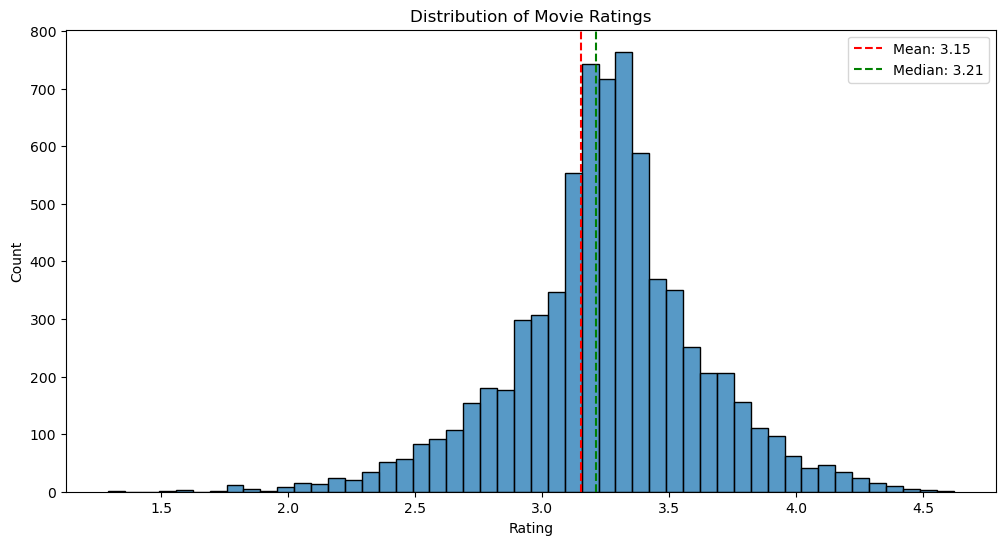

In [25]:
# 1. Rating Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train_movies_df, x='rating', bins=50)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.axvline(movies_df['rating'].mean(), color='red', linestyle='--', label=f'Mean: {movies_df["rating"].mean():.2f}')
plt.axvline(movies_df['rating'].median(), color='green', linestyle='--', label=f'Median: {movies_df["rating"].median():.2f}')
plt.legend()
plt.show()

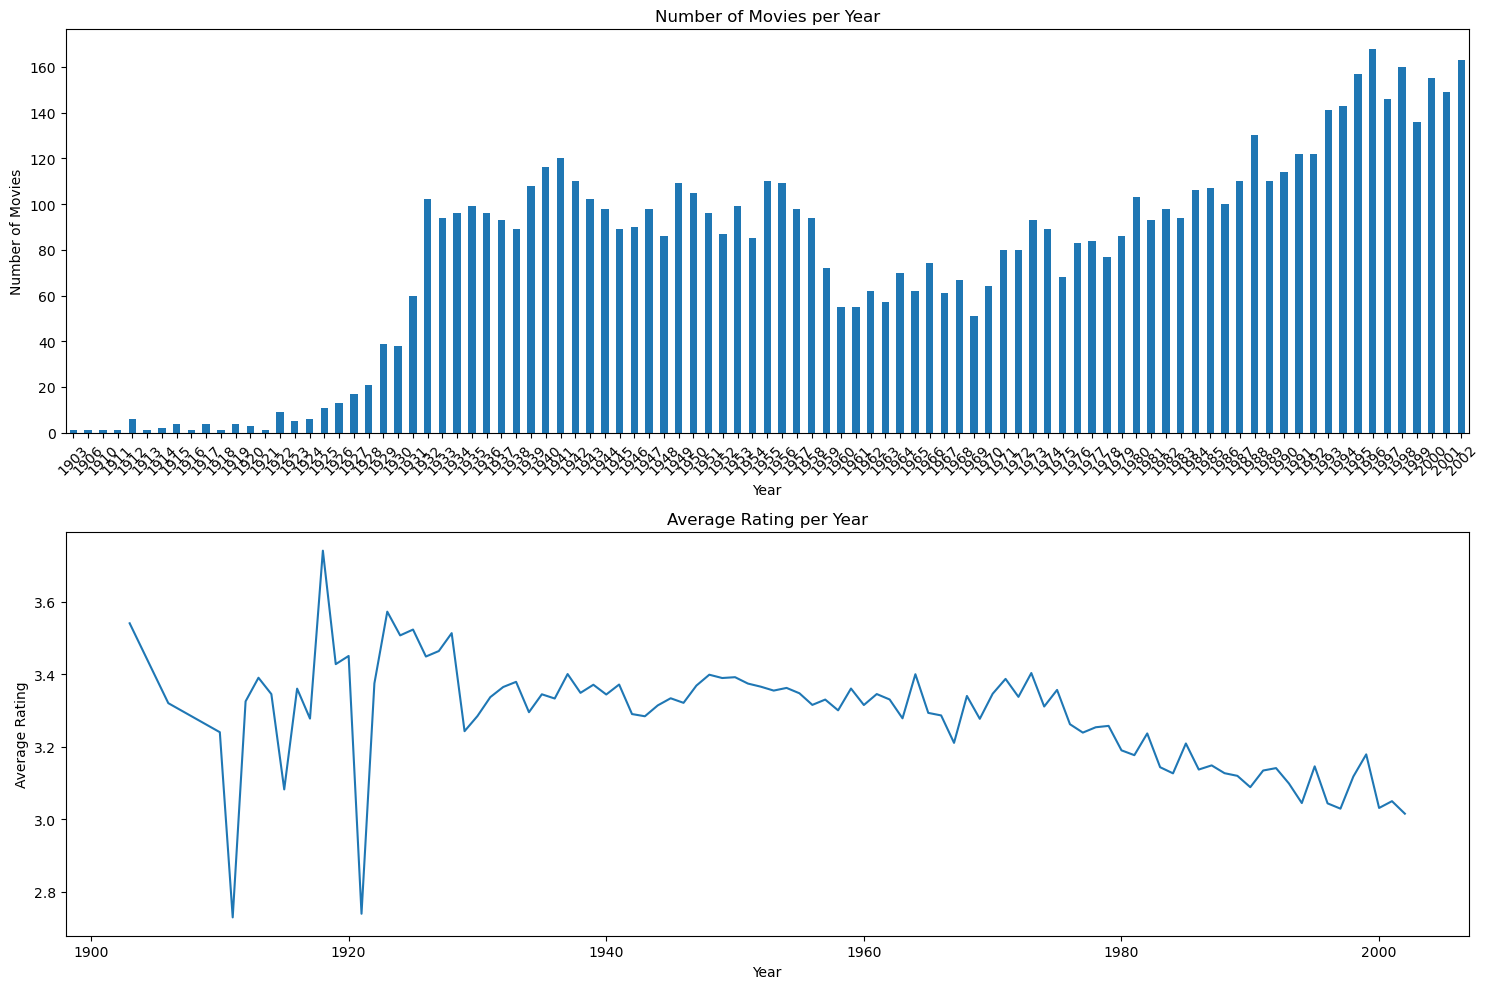

In [27]:
# 2. Temporal Analysis
yearly_counts = train_movies_df['date'].value_counts().sort_index()
yearly_ratings = train_movies_df.groupby('date')['rating'].mean()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
# Number of movies per year
yearly_counts.plot(kind='bar', ax=ax1)
ax1.set_title('Number of Movies per Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Movies')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
# Average rating per year
yearly_ratings.plot(kind='line', ax=ax2)
ax2.set_title('Average Rating per Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Rating')
plt.tight_layout()
plt.show()

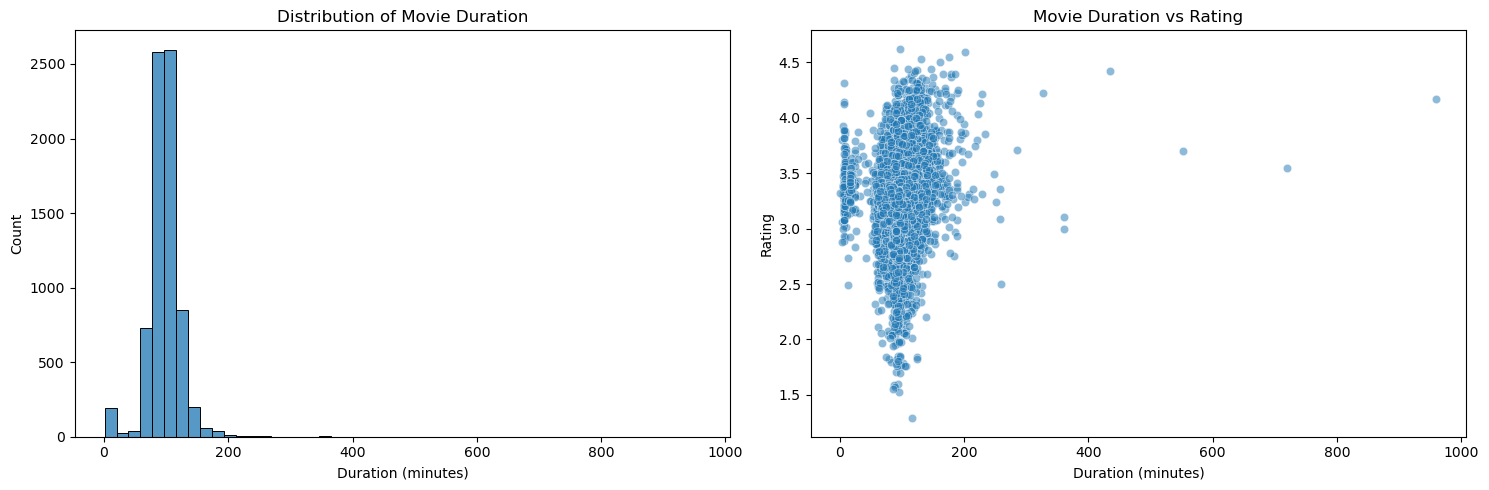

In [30]:
# 3. Movie Duration Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Duration distribution
sns.histplot(data=train_movies_df, x='minute', bins=50, ax=ax1)
ax1.set_title('Distribution of Movie Duration')
ax1.set_xlabel('Duration (minutes)')
ax1.set_ylabel('Count')
# Duration vs Rating
sns.scatterplot(data=train_movies_df, x='minute', y='rating', alpha=0.5, ax=ax2)
ax2.set_title('Movie Duration vs Rating')
ax2.set_xlabel('Duration (minutes)')
ax2.set_ylabel('Rating')
plt.tight_layout()
plt.show()

In [31]:
correlation = train_movies_df['minute'].corr(train_movies_df['rating'])
print(f"\nCorrelation between duration and rating: {correlation:.3f}")


Correlation between duration and rating: 0.137


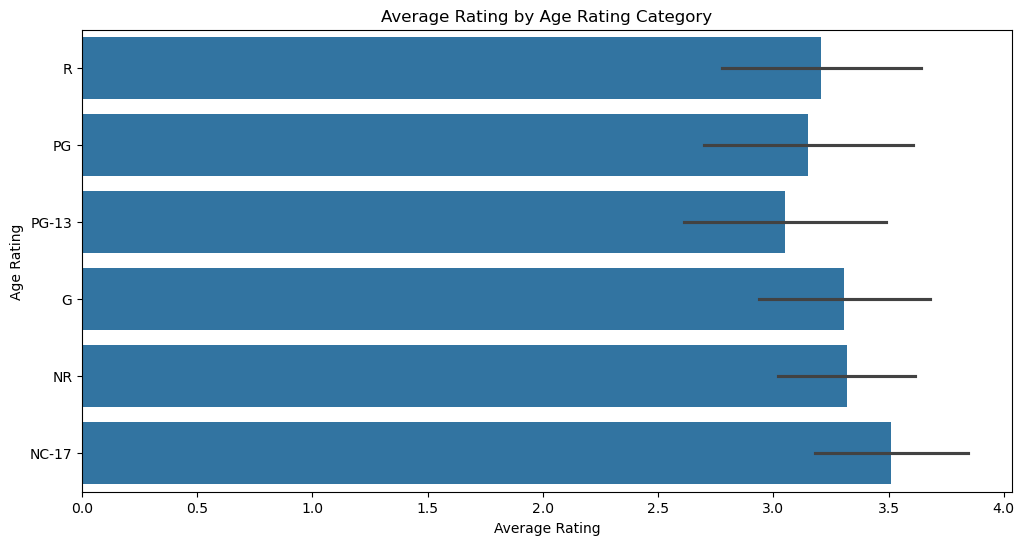


Age Rating Statistics:
                                mean  count    std
theatrical_release_age_rating                     
NC-17                          3.512     11  0.332
G                              3.308    317  0.370
PG-13                          3.050    689  0.438
PG                             3.153   1030  0.451
R                              3.208   1507  0.432
NR                             3.318   3791  0.297


In [33]:
# 4. Age Rating Analysis
plt.figure(figsize=(12, 6))
# Calculate average rating per age rating category
age_rating_stats = train_movies_df.groupby('theatrical_release_age_rating')['rating'].agg(['mean', 'count', 'std']).round(3)
age_rating_stats = age_rating_stats.sort_values('count', ascending=True)
# Create bar plot
sns.barplot(data=train_movies_df, y='theatrical_release_age_rating', x='rating', estimator='mean', errorbar='sd')
plt.title('Average Rating by Age Rating Category')
plt.xlabel('Average Rating')
plt.ylabel('Age Rating')
plt.show()
print("\nAge Rating Statistics:")
print(age_rating_stats)

In [66]:
# 5. Studio Analysis
studio_stats = pd.merge(train_movies_df, studios_df, on='original_id', how='left')


In [67]:
studio_stats.shape

(7718, 11)

In [ ]:
studio_analysis = studio_stats.groupby('studio').agg({
    'rating': ['mean', 'std']
}).round(3)

studio_analysis.columns = ['rating_mean', 'rating_std']


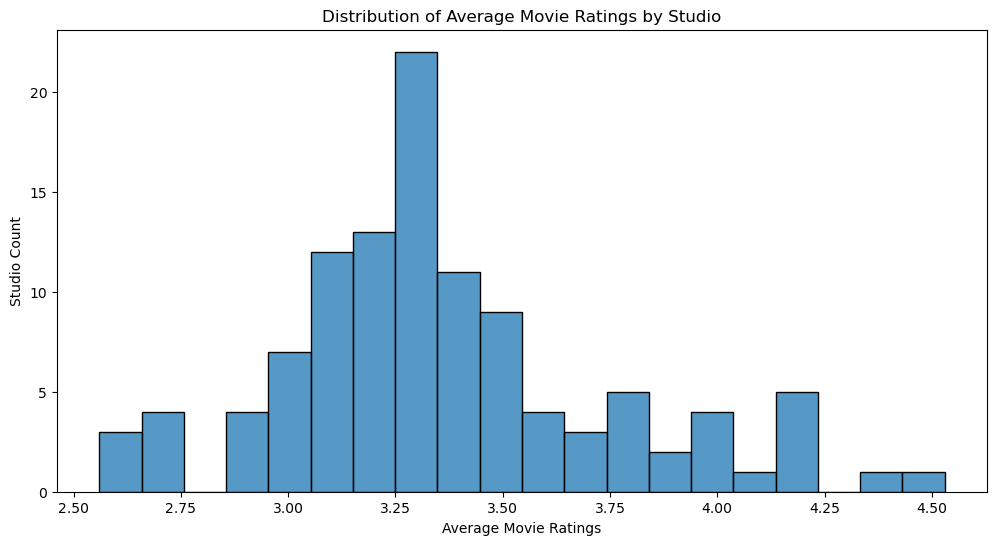

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=studio_analysis, x='rating_mean', bins=20)
plt.title('Distribution of Average Movie Ratings by Studio')
plt.xlabel('Average Movie Ratings')
plt.ylabel('Studio Count')
plt.show()

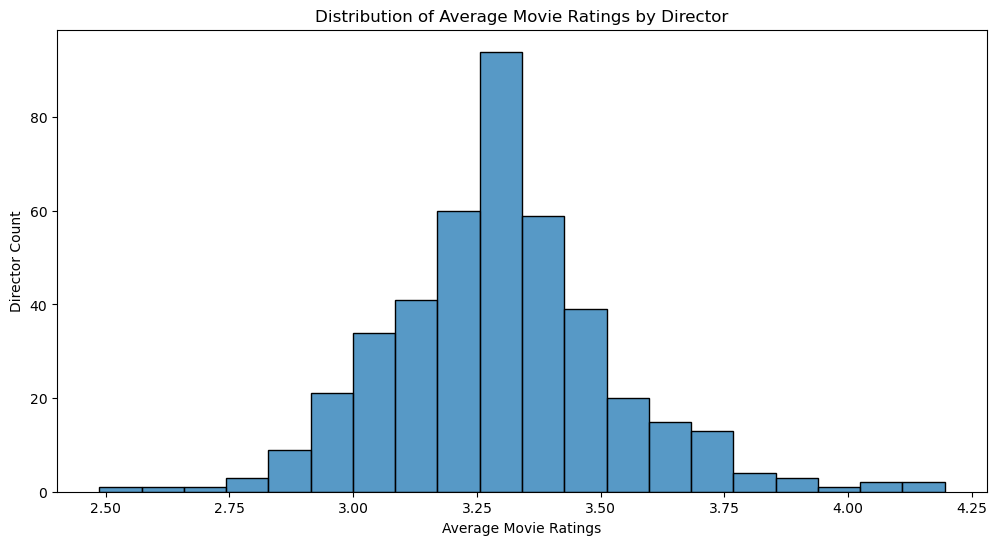

In [77]:
# 6. Director Analysis
director_stats = pd.merge(train_movies_df, directors_df, on='original_id')
director_analysis = director_stats.groupby('director_name').agg({
    'rating': ['mean', 'std']
}).round(3)
director_analysis.columns = ['rating_mean', 'rating_std']

plt.figure(figsize=(12, 6))
sns.histplot(data=director_analysis, x='rating_mean', bins=20)
plt.title('Distribution of Average Movie Ratings by Director')
plt.xlabel('Average Movie Ratings')
plt.ylabel('Director Count')
plt.show()

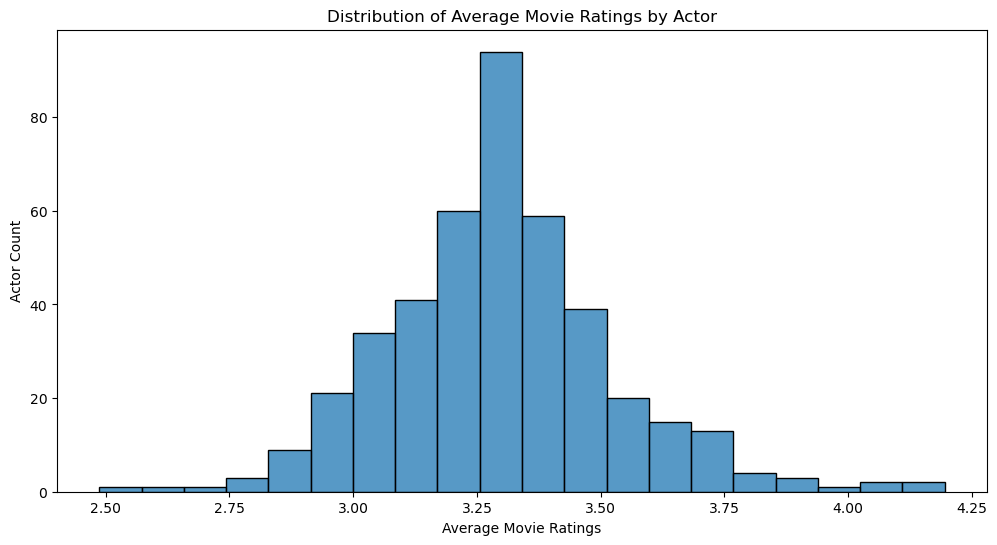

In [80]:
# 7. Actor Analysis
actor_stats = pd.merge(train_movies_df, actors_df, on='original_id')
actor_analysis = actor_stats.groupby('actor_name').agg({
    'rating': ['mean', 'std']
}).round(3)
actor_analysis.columns = ['rating_mean', 'rating_std']
plt.figure(figsize=(12, 6))
sns.histplot(data=director_analysis, x='rating_mean', bins=20)
plt.title('Distribution of Average Movie Ratings by Actor')
plt.xlabel('Average Movie Ratings')
plt.ylabel('Actor Count')
plt.show()

In [87]:
# 8. Embedding Analysis

# Load pre-computed embeddings
poster_embeddings = np.load('data/filtered/poster_embeddings.npy')[train_movies_df.index]
tagline_embeddings = np.load('data/filtered/tagline_embeddings.npy')[train_movies_df.index]
description_embeddings = np.load('data/filtered/description_embeddings.npy')[train_movies_df.index]


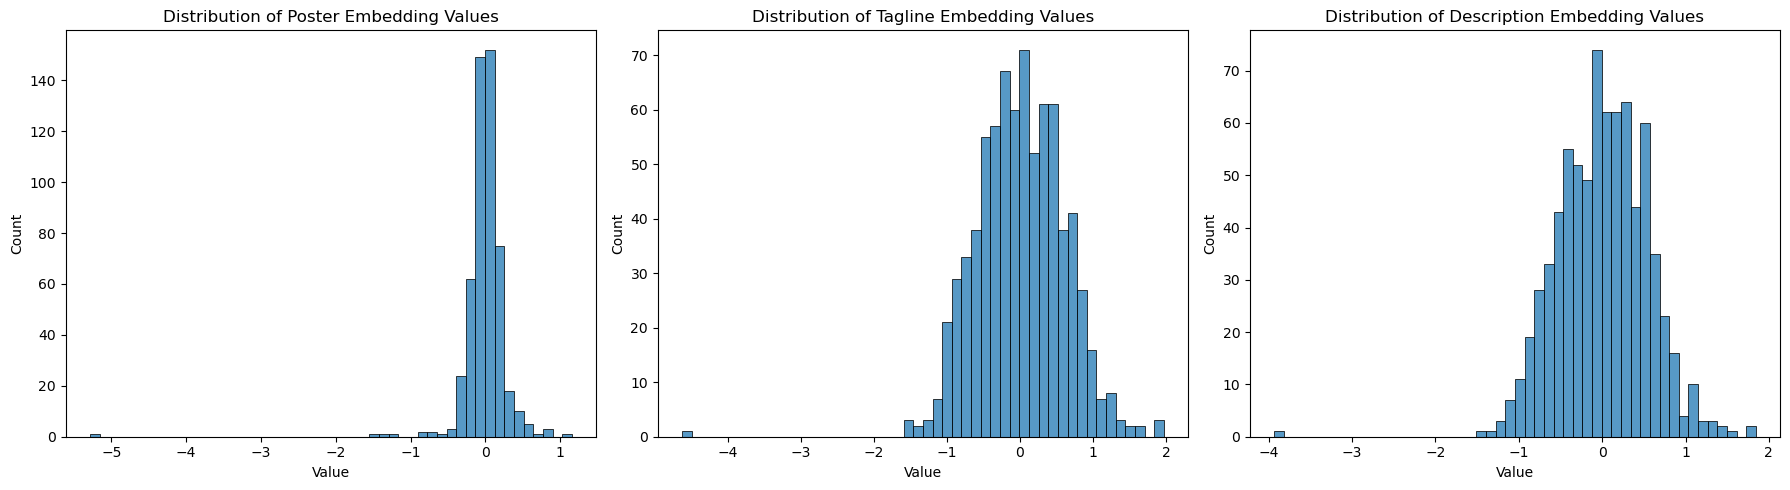

In [89]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
# Poster embeddings distribution
sns.histplot(poster_embeddings.mean(axis=0), bins=50, ax=ax1)
ax1.set_title('Distribution of Poster Embedding Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Count')
# Tagline embeddings distribution
sns.histplot(tagline_embeddings.mean(axis=0), bins=50, ax=ax2)
ax2.set_title('Distribution of Tagline Embedding Values')
ax2.set_xlabel('Value')
ax2.set_ylabel('Count')
# Description embeddings distribution
sns.histplot(description_embeddings.mean(axis=0), bins=50, ax=ax3)
ax3.set_title('Distribution of Description Embedding Values')
ax3.set_xlabel('Value')
ax3.set_ylabel('Count')
plt.tight_layout()
plt.show()

In [90]:
print("\nEmbedding Statistics:")
print(f"Poster embeddings - Mean: {poster_embeddings.mean():.3f}, Std: {poster_embeddings.std():.3f}")
print(f"Tagline embeddings - Mean: {tagline_embeddings.mean():.3f}, Std: {tagline_embeddings.std():.3f}")
print(f"Description embeddings - Mean: {description_embeddings.mean():.3f}, Std: {description_embeddings.std():.3f}") 


Embedding Statistics:
Poster embeddings - Mean: -0.008, Std: 0.442
Tagline embeddings - Mean: 0.006, Std: 0.792
Description embeddings - Mean: 0.004, Std: 0.721


# Feature engineering and selection

movies.csv: Contains the core movie information and our target variable (rating)

actors.csv, directors.csv, studios.csv: Contain entity relationships (one-to-many)

pre-computed embeddings for visual and textual content

theatrical_release_age_rating: Create one-hot encoding

minute: Use as is

For relational features, aggregate historical rating data from training movies to derive meaningful insights:

Actors:

Compute the average past ratings of actors.
Identify star actors associated with high-rated movies.

Directors:

Compute the average past ratings of directors.
Identify star directors linked to highly rated films.

Studios:

Compute the average past ratings of studios.
Identify star studios that produce high-rated movies.

In [ ]:
def calculate_historical_stats(df, entity_col, rating_col):
    """Calculate historical statistics for entities based on ratings.
    
    Args:
        df: DataFrame containing entity and rating columns
        entity_col: Column name for the entity (actor, director, or studio)
        rating_col: Column name for the rating
        
    Returns:
        DataFrame with entity statistics
    """
    # Ensure we have the column
    if entity_col not in df.columns:
        raise KeyError(f"Column {entity_col} not found in DataFrame. Available columns: {df.columns.tolist()}")
    
    stats = df.groupby(entity_col)[rating_col].agg([
        ('avg_rating', 'mean'),
        ('count', 'count')
    ]).reset_index()
    
    # Define "star" entities as those with above average ratings and at least 3 movies
    mean_rating = stats[stats['count'] >= 3]['avg_rating'].mean()
    stats['is_star'] = (stats['avg_rating'] > mean_rating) & (stats['count'] >= 3)
    
    return stats

In [ ]:
def get_entity_features(movies_df, entities_df, entity_type, rating_col='rating'):
    """Create features for entities (actors, directors, or studios).
    
    Args:
        movies_df: DataFrame containing movie information (indexed by original_id)
        entities_df: DataFrame containing entity relationships
        entity_type: Type of entity ('actor', 'director', or 'studio')
        rating_col: Column name for the rating
        
    Returns:
        DataFrame with entity-based features
    """
    # Define the correct ID column name based on entity type
    id_column = {
        'actor': 'actor_name',
        'director': 'director_name',
        'studio': 'studio'
    }[entity_type]
    

    # Merge movies with entities using original_id
    merged_df = pd.merge(
        entities_df,
        movies_df[[rating_col, 'date']],
        left_on='original_id',
        right_index=True
    )
        
    # Calculate historical statistics using only training data
    entity_stats = calculate_historical_stats(
        merged_df,
        id_column,
        rating_col,
        )

    # Create features for each movie
    movie_features = {}
    
    # Group by original_id to aggregate entity features
    grouped = merged_df.groupby('original_id')
    
    # Merge with entity statistics
    merged_with_stats = pd.merge(
        merged_df,
        entity_stats,
        on=id_column,
        how='left'
    )
    
    # Calculate features for each movie
    for original_id, group in grouped:
        # Get entity statistics for this movie
        movie_entities = merged_with_stats[merged_with_stats['original_id'] == original_id]
        
        features = {
            f'{entity_type}_count': len(group),
            f'avg_{entity_type}_rating': movie_entities['avg_rating'].mean(),
            f'star_{entity_type}_count': movie_entities['is_star'].sum(),
            f'has_star_{entity_type}': int(movie_entities['is_star'].any())
        }
        
        movie_features[original_id] = features
    
    return pd.DataFrame.from_dict(movie_features, orient='index')


In [94]:
def load_split_data():
    """Load the train/val/test split data."""
    with open('data/splits/split_indices.json', 'r') as f:
        split_indices = json.load(f)
    
    data_dir = Path('data/filtered')
    movies_df = pd.read_csv(data_dir / 'movies.csv')
    actors_df = pd.read_csv(data_dir / 'actors.csv')
    directors_df = pd.read_csv(data_dir / 'directors.csv')
    studios_df = pd.read_csv(data_dir / 'studios.csv')
    
    # Load embeddings
    poster_embeddings = np.load(data_dir / 'poster_embeddings.npy')
    tagline_embeddings = np.load(data_dir / 'tagline_embeddings.npy')
    description_embeddings = np.load(data_dir / 'description_embeddings.npy')
    
    # Split the data according to indices
    splits = {}
    for split_name in ['train', 'val', 'test']:
        indices = split_indices[split_name]
        splits[split_name] = {
            'movies': movies_df.loc[indices].copy(),
            'embeddings': {
                'poster': poster_embeddings[indices],
                'tagline': tagline_embeddings[indices],
                'description': description_embeddings[indices]
            }
        }
        # Get original_ids for the split
        original_ids = set(splits[split_name]['movies']['original_id'])
        splits[split_name].update({
            'actors': actors_df[actors_df['original_id'].isin(original_ids)].copy(),
            'directors': directors_df[directors_df['original_id'].isin(original_ids)].copy(),
            'studios': studios_df[studios_df['original_id'].isin(original_ids)].copy()
        })
    
    return splits

In [116]:
def engineer_categorical_numerical_features(split_data):
    """
    Engineer categorical and numerical features from movies and related data.
    
    Args:
        split_data (dict): Dictionary containing train/val/test split data
    
    Returns:
        dict: Dictionary containing engineered features for each split
    """
    # Initialize label encoders
    label_encoders = {
        'theatrical_release_age_rating': LabelEncoder()
    }
    
    # Initialize standard scaler
    scaler = StandardScaler()
    
    # Train encoders and scaler on training data
    train_movies = split_data['train']['movies']
    for col, encoder in label_encoders.items():
        encoder.fit(train_movies[col])
    
    # Select and prepare numerical features from movies
    numerical_features = ['minute']
    
    # Prepare features for each split
    engineered_features = {}
    for split_name, split in split_data.items():
        movies_df = split['movies']
        actors_df = split['actors']
        directors_df = split['directors']
        studios_df = split['studios']
        
        # Initialize features DataFrame with original_id as index
        features = pd.DataFrame(index=movies_df['original_id'])
        
        # 1. Basic movie features
        # Encode categorical variables
        for col, encoder in label_encoders.items():
            features[f'{col}_encoded'] = encoder.transform(movies_df[col])
        
        # Scale numerical features
        numerical_data = movies_df[numerical_features].fillna(movies_df[numerical_features].mean())
        if split_name == 'train':
            scaled_features = scaler.fit_transform(numerical_data)
        else:
            scaled_features = scaler.transform(numerical_data)
        features['duration'] = scaled_features
        
        # 3. Actor features
        actor_features = get_entity_features(
            movies_df.set_index('original_id'), 
            actors_df, 
            'actor',
            rating_col='rating'
        )
        features = features.join(actor_features, how='left')
        
        # 4. Director features
        director_features = get_entity_features(
            movies_df.set_index('original_id'), 
            directors_df, 
            'director',
            rating_col='rating'
        )
        features = features.join(director_features, how='left')
        
        # 5. Studio features
        studio_features = get_entity_features(
            movies_df.set_index('original_id'), 
            studios_df, 
            'studio',
            rating_col='rating'
        )
        features = features.join(studio_features, how='left')
        
        # Fill any missing values with 0
        features = features.fillna(0)
        
        # Store features for this split
        engineered_features[split_name] = features
    
    return engineered_features, label_encoders, scaler


In [102]:
def get_target_variables(split_data):
    """
    Extract target variables (ratings) from the splits.
    
    Args:
        split_data (dict): Dictionary containing train/val/test split data
    
    Returns:
        dict: Dictionary containing target variables for each split
    """
    targets = {}
    for split_name, split in split_data.items():
        targets[split_name] = split['movies']['rating'].values
    return targets

In [117]:
def analyze_engineered_features(features, targets):
    """
    Analyze and select the most relevant engineered features using correlation analysis
    and feature importance.
    
    Args:
        features (dict): Dictionary containing engineered features
        targets (dict): Dictionary containing target variables
    
    Returns:
        dict: Selected engineered features for each split
        list: Names of selected features
    """
    train_features, train_target = features['train'], targets['train']
    feature_names = ['duration', 'age_rating', 'actor_count', 'avg_actor_rating', 'star_actor_count', 'has_star_actor',
                     'director_count', 'avg_director_rating', 'star_director_count', 'has_star_director',
                     'studio_count', 'avg_studio_rating', 'star_studio_count', 'has_star_studio']
    
    X_train = np.column_stack([train_features['duration'], train_features['theatrical_release_age_rating_encoded'],
                               train_features['actor_count'], train_features['avg_actor_rating'],
                               train_features['star_actor_count'], train_features['has_star_actor'],
                               train_features['director_count'], train_features['avg_director_rating'],
                               train_features['star_director_count'], train_features['has_star_director'],
                               train_features['studio_count'], train_features['avg_studio_rating'],
                               train_features['star_studio_count'], train_features['has_star_studio']])
    
    # Correlation Analysis
    feature_df = pd.DataFrame(X_train, columns=feature_names)
    feature_df['rating'] = train_target
    correlation_matrix = feature_df.corr()['rating'].abs()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(feature_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('data/features/correlation_heatmap.png')
    plt.show()
    
    # Feature Importance using Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, train_target)
    importance_scores = pd.Series(rf.feature_importances_, index=feature_names)
    
    plt.figure(figsize=(12, 8))
    importance_scores.sort_values().plot(kind='barh')
    plt.title('Feature Importance Scores')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('data/features/feature_importance.png')
    plt.show()
    
    # Select features based on importance threshold
    final_features = importance_scores[importance_scores > importance_scores.mean()].index.tolist()
    
    with open('data/features/feature_selection_results.json', 'w') as f:
        json.dump({'correlation_scores': correlation_matrix.to_dict(),
                   'importance_scores': importance_scores.to_dict(),
                   'selected_features': final_features}, f, indent=2)
    
    # Filter features for all splits
    def extract_selected(features, selected):
        return np.hstack([np.array(features[name]).reshape(-1, 1) for name in selected if name in features])
    
    selected_features = {split: extract_selected(f, final_features) for split, f in features.items()}
    
    return selected_features, final_features

In [95]:
# Create output directories at the start
print("Creating output directories...")
output_dir = Path('data/features')
output_dir.mkdir(exist_ok=True, parents=True)

Creating output directories...


In [96]:
print("Loading split data...")
split_data = load_split_data()

Loading split data...


In [118]:
print("\nEngineering categorical and numerical features...")
categorical_numerical_features, label_encoders, scaler = engineer_categorical_numerical_features(split_data)
    


Engineering categorical and numerical features...
Merged DataFrame columns: ['movie_id', 'original_id', 'actor_name', 'rating', 'date']
Merged DataFrame columns: ['movie_id', 'original_id', 'director_name', 'rating', 'date']
Merged DataFrame columns: ['movie_id', 'original_id', 'studio', 'rating', 'date']
Merged DataFrame columns: ['movie_id', 'original_id', 'actor_name', 'rating', 'date']
Merged DataFrame columns: ['movie_id', 'original_id', 'director_name', 'rating', 'date']
Merged DataFrame columns: ['movie_id', 'original_id', 'studio', 'rating', 'date']
Merged DataFrame columns: ['movie_id', 'original_id', 'actor_name', 'rating', 'date']
Merged DataFrame columns: ['movie_id', 'original_id', 'director_name', 'rating', 'date']
Merged DataFrame columns: ['movie_id', 'original_id', 'studio', 'rating', 'date']



Extracting target variables...

Analyzing and selecting engineered features...


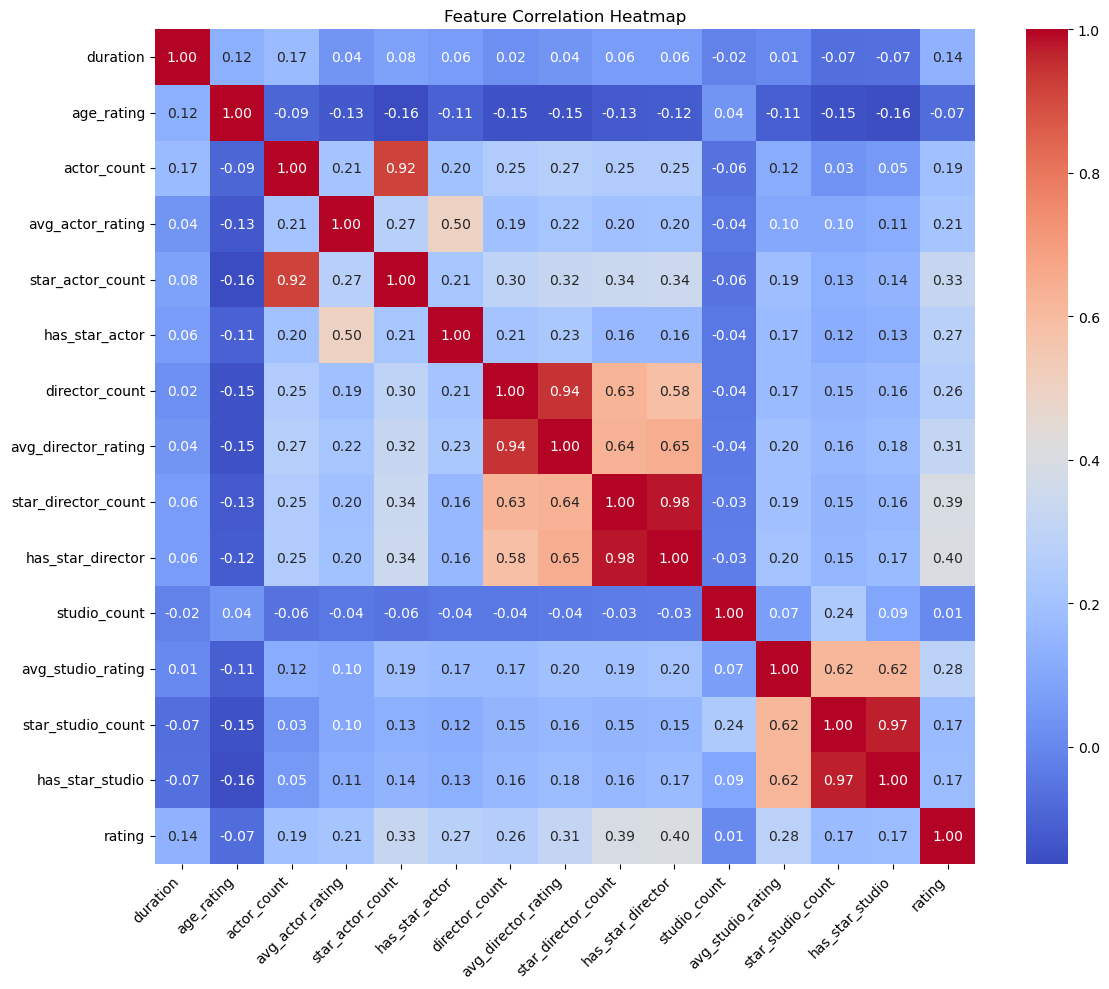

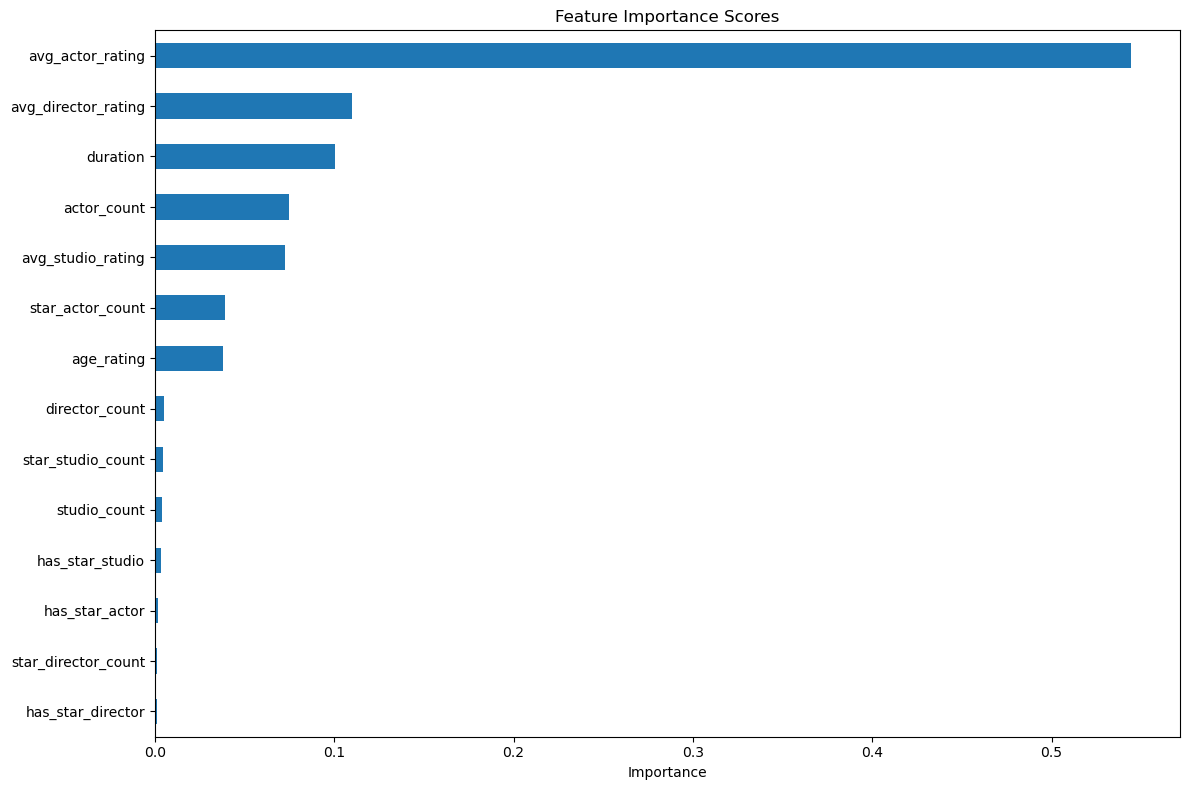

In [119]:
print("\nExtracting target variables...")
targets = get_target_variables(split_data)

print("\nAnalyzing and selecting engineered features...")
selected_features, feature_names = analyze_engineered_features(categorical_numerical_features, targets)
    

In [135]:
feature_names

['duration',
 'actor_count',
 'avg_actor_rating',
 'avg_director_rating',
 'avg_studio_rating']

 # Model development

Random Forest Performance:
Validation Evaluation:
MSE: 0.2501
MAE: 0.4208
R² Score: 0.2120



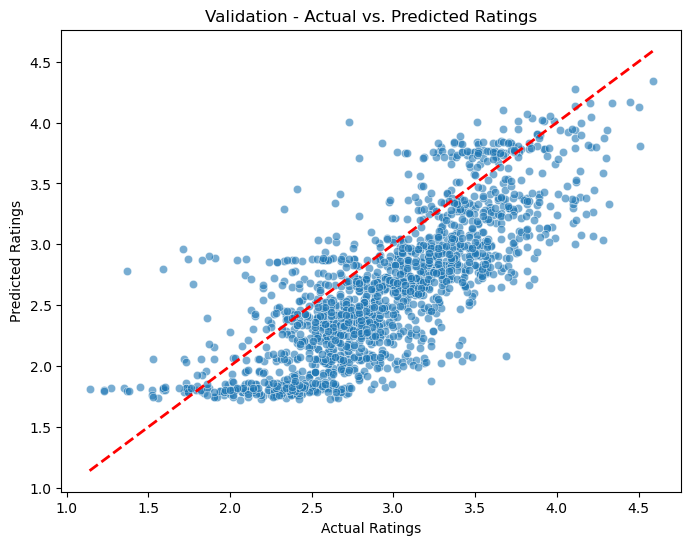

In [131]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Load selected features and targets
X_train = selected_features['train']  # Training features
y_train = targets['train']  # Training labels
X_val = selected_features['val']  # Validation features
y_val = targets['val']  # Validation labels


# Hyperparameter tuning for RandomForest
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_



# Evaluate models
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    print(f"{dataset_name} Evaluation:")
    print(f"MSE: {mean_squared_error(y, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y, y_pred):.4f}")
    print(f"R² Score: {r2_score(y, y_pred):.4f}\n")

    # Visualization
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y, y=y_pred, alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)
    plt.xlabel("Actual Ratings")
    plt.ylabel("Predicted Ratings")
    plt.title(f"{dataset_name} - Actual vs. Predicted Ratings")
    plt.show()

print("Random Forest Performance:")
evaluate_model(rf_best, X_val, y_val, "Validation")



Baseline Model Performance:
Baseline MSE: 1.2119
Baseline MAE: 0.9083
Baseline R² Score: -2.8193



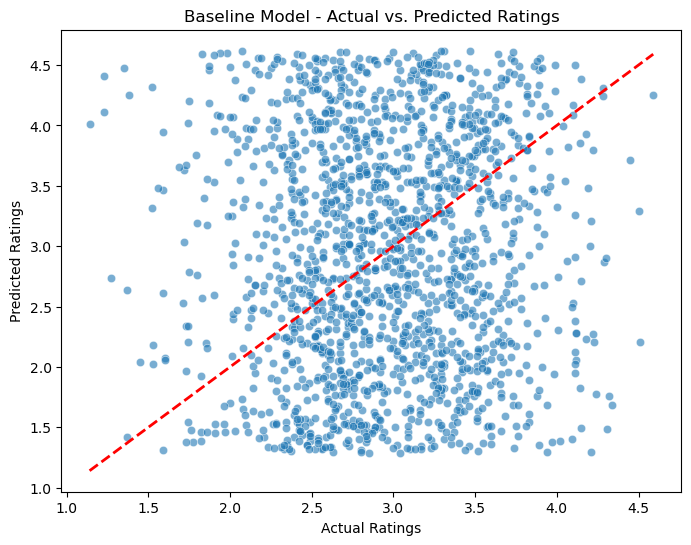

In [133]:
# Baseline Model: Random predictions within the range of training data
def baseline_model(X, y_train):
    min_value = y_train.min()
    max_value = y_train.max()
    y_pred_baseline = np.random.uniform(min_value, max_value, size=len(X))
    return y_pred_baseline

# Evaluate Baseline Model
print("Baseline Model Performance:")
y_pred_baseline = baseline_model(X_val, y_train)
print(f"Baseline MSE: {mean_squared_error(y_val, y_pred_baseline):.4f}")
print(f"Baseline MAE: {mean_absolute_error(y_val, y_pred_baseline):.4f}")
print(f"Baseline R² Score: {r2_score(y_val, y_pred_baseline):.4f}\n")

# Visualization for Baseline Model
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_baseline, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title(f"Baseline Model - Actual vs. Predicted Ratings")
plt.show()

Baseline Model (Mean Predictions) Performance:
Baseline (Mean) MSE: 0.4044
Baseline (Mean) MAE: 0.5145
Baseline (Mean) R² Score: -0.2745



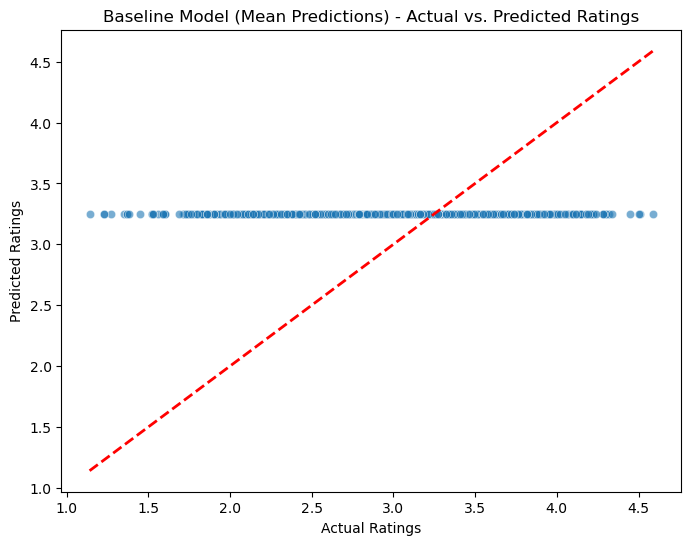

In [134]:
# Baseline Model 2: Always predicting the mean of the training data
def baseline_model_mean(X, y_train):
    mean_value = y_train.mean()
    y_pred_baseline_mean = np.full(len(X), mean_value)
    return y_pred_baseline_mean

# Evaluate Baseline Model 2 (Mean Predictions)
print("Baseline Model (Mean Predictions) Performance:")
y_pred_baseline_mean = baseline_model_mean(X_val, y_train)
print(f"Baseline (Mean) MSE: {mean_squared_error(y_val, y_pred_baseline_mean):.4f}")
print(f"Baseline (Mean) MAE: {mean_absolute_error(y_val, y_pred_baseline_mean):.4f}")
print(f"Baseline (Mean) R² Score: {r2_score(y_val, y_pred_baseline_mean):.4f}\n")

# Visualization for Baseline Model 2
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_baseline_mean, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title(f"Baseline Model (Mean Predictions) - Actual vs. Predicted Ratings")
plt.show()

 # To do

For the text features with pre-computed embeddings:

tagline: The embeddings capture semantic meaning, but also consider:

Sentiment analysis (positive/negative tone)

description: Named entity recognition to identify additional genres or themes